In [27]:
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from nle import nethack

In [28]:
device = torch.device('cpu')
seed = 1
max_episode_steps = 2000
window = 25
gamma = 0.99
alpha = 0.1
render = False
max_glyph = nethack.MAX_GLYPH

In [29]:
ACTIONS = [
    nethack.CompassCardinalDirection.N,
    nethack.CompassCardinalDirection.E,
    nethack.CompassCardinalDirection.S,
    nethack.CompassCardinalDirection.W,
]

In [30]:
STATS_INDICES = {
    'x_coordinate': 0,
    'y_coordinate': 1,
    'score': 9,
    'health_points': 10,
    'health_points_max': 11,
    'hunger_level': 18,
}

In [38]:
env = gym.make("NetHackScore-v0", actions = ACTIONS)
env.seed(seed)
torch.manual_seed(seed)

In [39]:
#env.render() # How to see the environment
#env.step(action) # How to step through the environment 0 = UP, 1 = Right, 2 = Down, 3 = Left

In [40]:
class Policy(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(obs_size, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.affine2 = nn.Linear(256, 128)
#         self.dropout = nn.Dropout(p=0.5)
        self.affine3 = nn.Linear(128, 64)
#        self.dropout = nn.Dropout(p=0.4)
        self.affine4 = nn.Linear(64, act_size)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.affine2(x)
#         x = self.dropout(x)
        x = F.relu(x)
        x = self.affine3(x)
#         x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine4(x)
        return F.softmax(action_scores, dim=1)

In [41]:
def crop_glyphs(glyphs, x, y, size=7):
    x_max = 79
    y_max = 21

    x_start = x - size
    x_end = x + size

    if x_start < 0:
        x_end = x_end + (-1 * x_start)
        x_start = 0

    if x_end > x_max:
        x_start = x_start - (x_end - x_max)
        x_end = x_max

    y_start = y - size
    y_end = y + size

    if y_start < 0:
        y_end = y_end + (-1 * y_start)
        y_start = 0

    if y_end > y_max:
        y_start = y_start - (y_end - y_max)
        y_end = y_max

    y_range = np.arange(y_start, (y_end), 1)
    x_range = np.arange(x_start, (x_end), 1)
    window_glyphs = []
    for row in y_range:
        for col in x_range:
            window_glyphs.append(glyphs[row][col])

    crop = np.asarray(window_glyphs)

    return crop

In [42]:
def transform_observation(observation):
    """Process the state into the model input shape
    of ([glyphs, stats], )"""
#     observed_glyphs = observation['glyphs']

    stat_x_coord = observation['blstats'][STATS_INDICES['x_coordinate']]
    stat_y_coord = observation['blstats'][STATS_INDICES['y_coordinate']]
#     stat_health = float(observation['blstats'][STATS_INDICES['health_points']]) - float(
#         observation['blstats'][STATS_INDICES['health_points_max']] / 2)
#     stat_hunger = observation['blstats'][STATS_INDICES['hunger_level']]


    observed_chars = observation['glyphs']
    cropped_chars = crop_glyphs(observed_chars, stat_x_coord, stat_y_coord)
    # chars_mean = np.mean(cropped_chars)
    # chars_std = np.std(cropped_chars)
    # print('MEAN:', chars_mean)
    # print('STD:', chars_std)
    # norm_chars = (cropped_chars - chars_mean)/chars_std
#     chars_min = np.min(cropped_chars)
#     chars_max = np.max(cropped_chars)
#     chars_range = chars_max - chars_min
#     norm_chars = (cropped_chars - chars_min) / chars_range
    norm_chars = cropped_chars/max_glyph
    return norm_chars

In [43]:
#get observation size
#but change observation size to characters just around agent
state = transform_observation(env.reset())

In [44]:
policy = Policy(state.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [45]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

In [46]:
print(state)
print(type(state))
print(state.shape)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.39524766
 0.39508032 0.39508032 0.39508032 0.39508032 0.39541499 0.
 0.         0.         0.         0.         0.         0.
 0.         0.39491299 0.39792503 0.39792503 0.39792503 0.39792503
 0.39491299 0.         0.         0.         0.         0.
 0.         0.         0.         0.39725569 0.39792503 0.39792503
 0.06910977 0.39792503 0.39491299 0.         0.         0.
 0.         0.         0.       

In [47]:
action = select_action(state)

In [48]:
action

2

In [49]:
episode_rewards = []
episode_loss = []

In [50]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    episode_loss.append(policy_loss)
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [51]:
def main():
    running_reward = 0
    for i_episode in range(1,300):
        state, ep_reward = transform_observation(env.reset()), 0
        for t in range(1, max_episode_steps):  # Don't infinite loop while learning
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            if render:
                env.render()
            state = transform_observation(state)
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        
        
        episode_rewards.append(ep_reward)
        running_reward = alpha * ep_reward + (1 - alpha) * running_reward
        finish_episode()

        if i_episode % window == 0:
            print('Episode {}\tLast reward: {:.2f}\tLast action: {}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, action, (sum(episode_rewards)/i_episode)))
#         if running_reward > 20:
#             print("Alert! Running reward is now {} and "
#                   "the last episode runs to {} time steps!".format(running_reward, t))
        if ((sum(episode_rewards)/i_episode) > 100) or ((sum(episode_rewards)/i_episode) < -25):
            print("End! Average reward is now {}".format((sum(episode_rewards)/i_episode)))
            break

In [52]:
main()

Episode 25	Last reward: -12.25	Last action: 3	Average reward: 16.42
Episode 50	Last reward: 25.06	Last action: 2	Average reward: 15.83
Episode 75	Last reward: -6.05	Last action: 3	Average reward: 13.79
Episode 100	Last reward: -12.34	Last action: 1	Average reward: 13.49
Episode 125	Last reward: 15.82	Last action: 2	Average reward: 12.81
Episode 150	Last reward: 17.76	Last action: 2	Average reward: 13.37
Episode 175	Last reward: 0.45	Last action: 3	Average reward: 15.80
Episode 200	Last reward: 16.81	Last action: 3	Average reward: 14.75
Episode 225	Last reward: -3.77	Last action: 0	Average reward: 13.00
Episode 250	Last reward: -12.96	Last action: 3	Average reward: 12.05
Episode 275	Last reward: -19.25	Last action: 3	Average reward: 10.66


In [53]:
torch.save(policy, '/home/clarise/Desktop/COMS7053A - RL/mod_glyphs1.pt')

In [54]:
import matplotlib.pyplot as plt

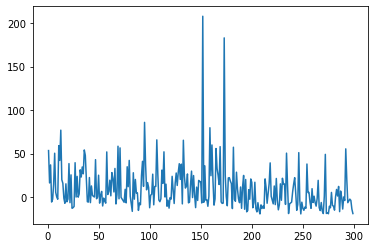

In [55]:
x = np.arange(1, len(episode_rewards)+1, 1)
y = episode_rewards
plt.plot(x,y)
plt.show()

In [56]:
avg = []
for i in range(x.shape[0]):
    rewards = sum(y[0:i])
    print(i, rewards)
    avg.append(rewards/x[i])
print(len(avg))

0 0
1 53.390000000001905
2 69.56000000000202
3 106.48000000000278
4 100.70000000000289
5 98.09000000000299
6 112.76000000000253
7 163.11000000000317
8 168.5200000000033
9 168.59000000000339
10 166.03000000000353
11 225.0900000000039
12 267.1300000000039
13 343.99000000000365
14 363.83000000000334
15 379.6700000000033
16 378.31000000000336
17 371.08000000000345
18 386.240000000003
19 380.74000000000314
20 378.38000000000335
21 416.7900000000035
22 410.26000000000363
23 435.7300000000022
24 422.7500000000024
25 410.5000000000026
26 399.5900000000028
27 439.02000000000254
28 438.97000000000264
29 462.7000000000023
30 462.5200000000024
31 466.01000000000255
32 497.2600000000022
33 520.2400000000023
34 554.7500000000032
35 581.420000000003
36 635.5300000000038
37 683.3800000000034
38 705.5000000000032
39 700.0900000000033
40 694.2500000000035
41 716.6300000000032
42 710.1400000000033
43 722.8600000000033
44 724.7700000000034
45 725.4100000000035
46 725.4300000000036
47 768.3800000000035
48 

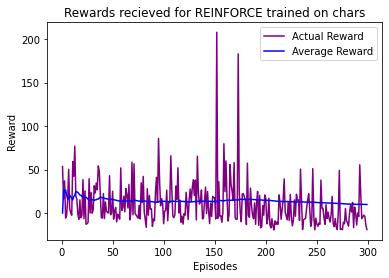

In [57]:
x = np.arange(1, len(episode_rewards)+1, 1)
y = episode_rewards
plt.plot(x,y, color = 'Purple', label = 'Actual Reward')
plt.plot(x, avg, color = 'Blue', label = 'Average Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards recieved for REINFORCE trained on chars')
plt.legend()
plt.show()